Description: Opt-out Rate Predictions

Author: Elena (Chaoran) Gou

Last Update: 08/14/2021

In [51]:
import pandas as pd
import numpy as np

import sys
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

np.random.seed(2000)

In [52]:
### Twilio brand colors: https://www.twilio.com/brand/resources/colorresources

# Primary Twilio brand colors
tw_red = '#F22F46'
night = '#001489'

# Secondary Twilio brand colors
blue = '#008CFF' # blue_50
green = '#36D576' # green_50
tangerine = '#F47C22' 
yellow = '#FFDD35' #yellow_40
purple = '#8C5BD8' #purple_50

# extended pallete
gray_30 = '#CACDD8' 
red_30 = '#f6b1b1' 
orange_30 = '#FAC2A0' 
green_30 = '#A2F6C3'
blue_30 = '#99CDFF'
purple_30 = '#C8AFF0'
gray_70 = '#4B5671'
red_70 = '#ad1111'
orange_70 = '#C35323'
green_70 = '#0E7C3A'
blue_70 = '#043CB5'
yellow_70 = '#C28E00'
purple_70 = '#5817BD'

teal = '#00BCD4'
mauve = '##DEA7E8'

charting_colors = [blue, green, tangerine, purple, yellow, tw_red, night, 
                   gray_30, red_30, blue_30, orange_30, green_30, purple_30,
                   gray_70, red_70, blue_70, orange_70, green_70, purple_70]

#'#FF5722', '#FA9950', '#FAD100', '#4CB04F', '#36D576', '#303F9F', '#2196F3', '#00BCD4', '#00E5FF', '#7B1FA2', '#7C4DFF', '#880E4F', '#DEA7E8', '#FF4081', '#9E9E9E'


# Twilio fonts
fonts = ['Helvetica Neue', 'Helvetica', 'Arial', 'sans-serif']

# set colors and fonts
sns.set_style('ticks', {'axes.linewidth': 2., 'font.sans-serif': fonts, 'font.family': 'Helvetica Neue'})
plt.rc('figure', figsize=(16, 10))
sns.set_context('poster', font_scale=1.0)
sns.set_palette(charting_colors)

### Read in Datasets

In [53]:
account = pd.read_csv('feature_engineered_May.csv')
account.head()

,attempted,account_sid,delivered,optouts,_7726,unreachable,_30007,_30008,_21610,aup,...,friendly_name,default_name,optout_perc,_7726_perc,_30008_perc,_30007_perc,_21610_perc,unreachable_perc,aup_perc,fraud_perc
0,291830197,AC0c4da9c0a8c20ea8890c2ca186768bed,279827613.0,0.0,383.0,10232167,677429,671412,3538,0.0,...,us-east-1,0.0,0.000000,0.000001,0.002301,0.002321,0.000012,0.035062,0.0,0.0
1,770805,ACbdccf1d7b857189e72fdb51c878d34db,768406.0,0.0,0.0,1674,0,725,0,0.0,...,Samsung,0.0,0.000000,0.000000,0.000941,0.000000,0.000000,0.002172,0.0,0.0
2,92827,AC21e3df471603c934315eb61694a18ab2,90908.0,1.0,0.0,935,0,984,0,0.0,...,j.teichert@vivenu.com's Account,0.0,0.000011,0.000000,0.010600,0.000000,0.000000,0.010073,0.0,0.0
3,4682,AC4be872f5cb700cf41676089db563bbc9,4518.0,0.0,0.0,158,3,2,0,0.0,...,Meevo M2NA0_ T10713-Tenant: 45206,0.0,0.000000,0.000000,0.000427,0.000641,0.000000,0.033746,0.0,0.0
4,25605,AC4cac4fec76a9decc2838641318025fa6,22138.0,327.0,3.0,3432,9,26,0,0.0,...,k.morrisonhealthadvisor@gmail.com,0.0,0.014771,0.000136,0.001015,0.000351,0.000000,0.134036,0.0,0.0


In [54]:
june = pd.read_csv('feature_engineered_June.csv')
june.head()

,attempted,account_sid,delivered,optouts,_7726,cannabis,unreachable,_30007,_30008,_21610,...,_30008_perc,_30007_perc,_21610_perc,unreachable_perc,aup_perc,fraud_perc,age,parent,isv,fam_size
0,26038,AC9f3116fcac59b5b68a451cba28f5a731,23407.0,1354.0,1.0,0,15,0,2616,0,...,0.100469,0.000000,0.000000,0.000576,0.0,0.0,5,1,1,682
1,536793,AC06ea2a0e2f80d342b45f46e42571dd02,504624.0,479.0,0.0,0,31670,183,316,0,...,0.000589,0.000341,0.000000,0.058999,0.0,0.0,68,0,0,3
2,2278,AC9d6d9155f700898c3f4fb05c4e90188b,2240.0,0.0,0.0,0,4,0,27,0,...,0.011853,0.000000,0.000000,0.001756,0.0,0.0,31,0,0,1
3,22281,ACac15107fc288db00551d7d26bc4cc764,19295.0,132.0,0.0,0,1191,0,266,1475,...,0.011938,0.000000,0.066200,0.053454,0.0,0.0,68,0,0,7
4,550054,AC55880b122abfcb40df3510b02f02ed9e,521606.0,0.0,0.0,0,27300,1,582,142,...,0.001058,0.000002,0.000258,0.049631,0.0,0.0,20,1,1,82


### Decision Tree

In [55]:
feature_perc = ['age','isv','parent','unreachable_perc',
       '_30007_perc', '_21610_perc', '_30008_perc', 
       'aup_perc','fraud_perc','cannabis','fam_size', 'default_name']

In [56]:
#Train test split
train, test = train_test_split(account, test_size=0.3)
x_train = train[feature_perc]
y_train = train['optout_perc']

x_test = test[feature_perc]
y_test = test['optout_perc']

#Create prediction data
X=june[feature_perc]
y=june['optout_perc']

#Generate values to calculate mean RMSE
y_bar = [y.mean()]*len(y)
train_bar = [y_train.mean()]*len(y_train)
test_bar = [y_test.mean()]*len(y_test)

Reference: https://medium.com/@mohtedibf/indepth-parameter-tuning-for-decision-tree-6753118a03c3

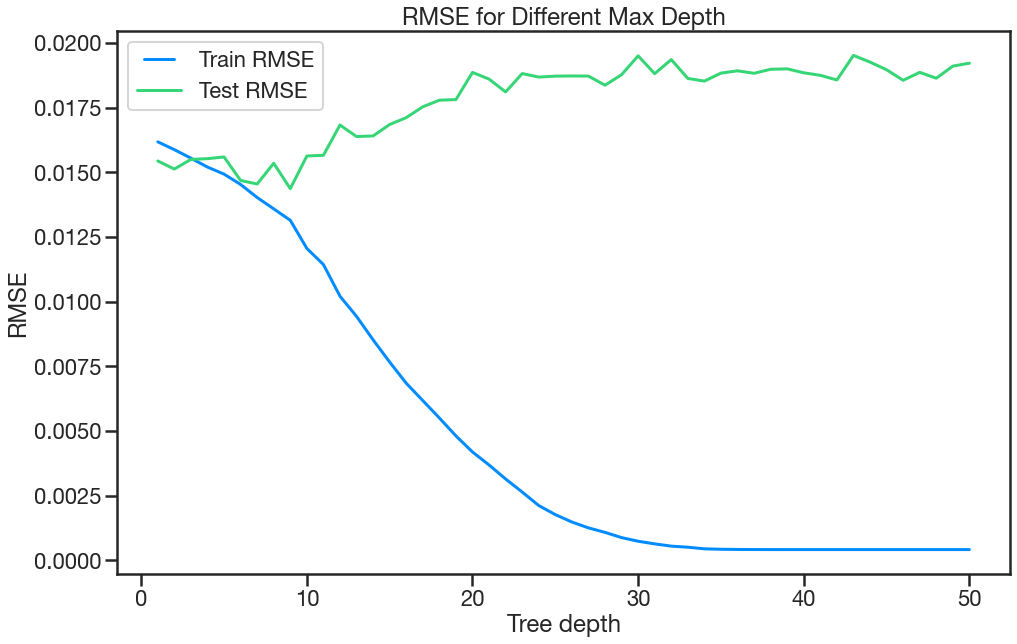

In [57]:
index = np.linspace(1, 50, 50, endpoint=True)
result = pd.DataFrame(index = index, columns=('train_results', 'test_results'))
for max_depth in index:
   dt = DecisionTreeRegressor(max_depth=max_depth)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   # Add rmse
   result.at[max_depth,'train_results']=np.sqrt(metrics.mean_squared_error(y_train, train_pred))
   test_pred = dt.predict(x_test)
   result.at[max_depth,'test_results']=np.sqrt(metrics.mean_squared_error(y_test, test_pred))

# Plotting RMSE for different tree depths
line1, = plt.plot(index, result['train_results'], label='Train RMSE')
line2, = plt.plot(index, result['test_results'], label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('RMSE for Different Max Depth')
plt.ylabel('RMSE')
plt.xlabel('Tree depth')
plt.show()

In [64]:
result['test_results'] = pd.to_numeric(result['test_results'])
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
optimal_dep = result['test_results'].idxmin()
print("Optimal Max Depth: ",optimal_dep)
print("Smallest RMSE: ",min(result['test_results']))

Root Mean Squared Error w mean: 0.014416552295850734
Optimal Max Depth:  9.0
Smallest RMSE:  0.014366537077820705


In [31]:
#Tree depth of 9 has the best result
regr = tree.DecisionTreeRegressor(max_depth=optimal_dep,random_state=0)
regr.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=7, random_state=0)

In [33]:
#R-squared
regr.score(x_train,y_train)

0.32256112886413657

In [34]:
regr.score(x_test,y_test)

0.049940038426687594

In [35]:
feature_importance = pd.DataFrame({"feature": x_test.columns,
                                 "importance": regr.feature_importances_})
feature_importance.sort_values(by='importance',ascending = False)

,feature,importance
10,fam_size,0.266737
4,_30007_perc,0.216465
3,unreachable_perc,0.197198
0,age,0.143794
5,_21610_perc,0.070155
6,_30008_perc,0.054291
2,parent,0.044016
1,isv,0.004598
8,fraud_perc,0.002747
7,aup_perc,0.000000


### Prediction

In [40]:
#Predict June opt-out rate and view top 10 predicted values
def get_top(string):
    june[string]=regr.predict(X)
    return june.sort_values(by=string,ascending=False)[['account_sid','optout_perc',string]].head(10)

In [35]:
#Compare predict and actual optout rates
get_top('dt_perc_predict')

,account_sid,optout_perc,dt_perc_predict
66939,AC18908b6026b4c2aa0f2cec5b902eeb42,0.500000,0.333333
62492,ACdb015f66175dedea9482a206c48f93bb,0.009485,0.213205
5143,AC66de5f7f805cd71f8d1a6e9eccd3cd3c,0.193798,0.213205
74879,ACacec2274244b2eef23cc561dd07b4b36,0.113825,0.213205
44441,AC1066e4ff1d19d8e8df76296ff830a728,0.008130,0.213205
18971,AC825d2b2ae001795b902089a419a68519,0.000528,0.213205
46331,AC424a7681cea5aa1dfff52f7e46bc9cc6,0.004393,0.162613
16345,AC8e6777502743ca511802da27ce5bef25,0.005511,0.156398
47125,AC7a1fb152c1b0b49050f0ebcba8aa3dd1,0.053514,0.144394
37559,AC4b21c4d22f6919950d930e6dc4c9b8e7,0.069461,0.110480


### Random Forest

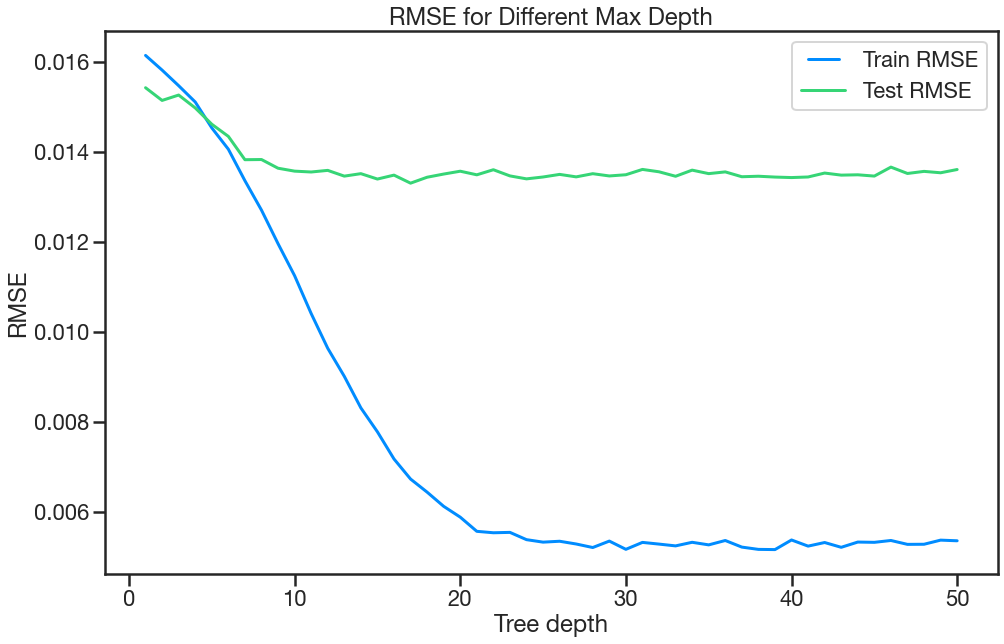

In [42]:
index = np.linspace(1, 50, 50, endpoint=True)
result = pd.DataFrame(index = index, columns=('train_results', 'test_results'))
for max_depth in index:
   dt = RandomForestRegressor(max_depth=max_depth)
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   # Add rmse
   result.at[max_depth,'train_results']=np.sqrt(metrics.mean_squared_error(y_train, train_pred))
   test_pred = dt.predict(x_test)
   result.at[max_depth,'test_results']=np.sqrt(metrics.mean_squared_error(y_test, test_pred))

# Plotting RMSE for different tree depths
line1, = plt.plot(index, result['train_results'], label='Train RMSE')
line2, = plt.plot(index, result['test_results'], label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('RMSE for Different Max Depth')
plt.ylabel('RMSE')
plt.xlabel('Tree depth')
plt.show()

In [43]:
result['test_results'] = pd.to_numeric(result['test_results'])
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
optimal_dep = result['test_results'].idxmin()
print("Optimal Max Depth: ",optimal_dep)
print("Smallest RMSE: ",min(result['test_results']))

Root Mean Squared Error w mean: 0.014416552295850734
Optimal Max Depth: 17
Smallest RMSE: 0.013301885356089189


In [40]:
#Tree Depth of 17 has the best result
regr = RandomForestRegressor(max_depth=optimal_dep, random_state=0)
regr.fit(x_train,y_train)

RandomForestRegressor(max_depth=17, random_state=0)

In [41]:
regr.score(x_train,y_train)

0.8294793498155462

In [42]:
regr.score(x_test,y_test)

0.3296749727592321

In [43]:
feature_importance = pd.DataFrame({"feature": x_test.columns,
                                 "importance": regr.feature_importances_})
feature_importance.sort_values(by='importance',ascending = False)

,feature,importance
3,unreachable_perc,2.291042e-01
10,fam_size,2.088504e-01
4,_30007_perc,1.884389e-01
0,age,1.456077e-01
6,_30008_perc,1.413660e-01
5,_21610_perc,5.106814e-02
1,isv,2.193192e-02
2,parent,1.126343e-02
8,fraud_perc,2.124954e-03
7,aup_perc,2.441203e-04


In [44]:
get_top('rf_perc_predict')

,account_sid,optout_perc,rf_perc_predict
48831,AC6047438797798f94e68720c01c15daed,0.334293,0.420553
66939,AC18908b6026b4c2aa0f2cec5b902eeb42,0.500000,0.200032
73042,AC45909a898b64f088a1f2042a57f183a0,0.030817,0.157276
24853,AC50209036fe9be99006c7f3036d4e12f1,0.001340,0.151128
77338,ACc8f6ce8009ac8c3949fcb22458544f36,0.223856,0.125632
30484,ACf405582861bfa1258a6aa34c1214ef46,0.045399,0.119040
74488,AC69d1d56fefd6f36a5e46bcd3fd7a676d,0.181490,0.117921
35428,ACe97fdff3a7021c9ef4baf3c01e2ff4b3,0.004857,0.117737
33267,AC1cd3fce6bb919df985d6320ff7ccb68e,0.025465,0.117239
48978,AC5e7e4ab31fa2ef267d6392c14171c7ed,0.035821,0.112881


### KNN 

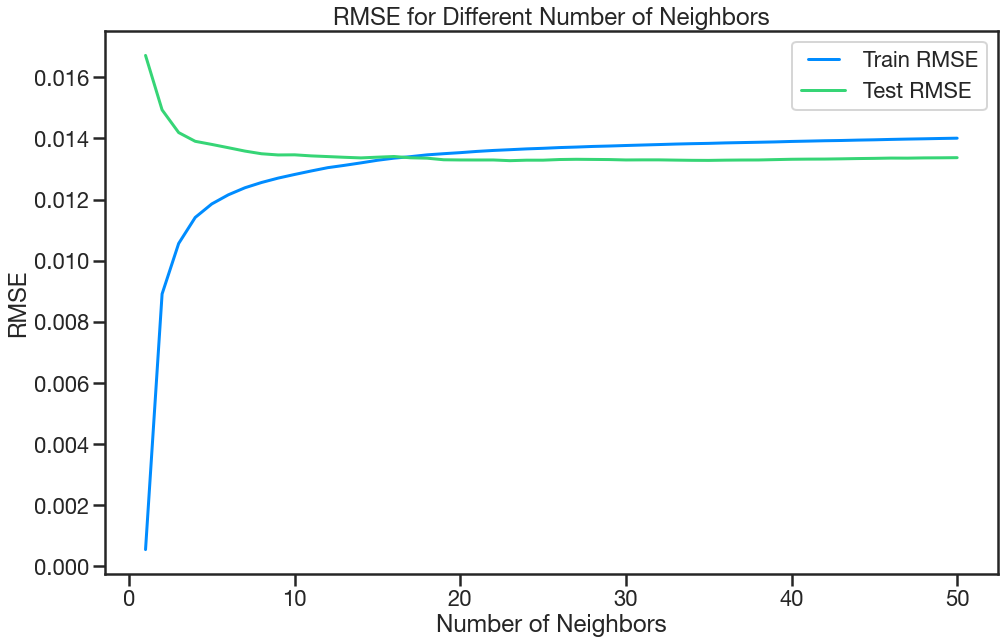

In [45]:
index = np.linspace(1, 50, 50, endpoint=True)
result = pd.DataFrame(index = index, columns=('train_results', 'test_results'))
for n in index:
   dt = KNeighborsRegressor(n_neighbors=int(n))
   dt.fit(x_train, y_train)
   train_pred = dt.predict(x_train)
   # Add rmse
   result.at[n,'train_results']=np.sqrt(metrics.mean_squared_error(y_train, train_pred))
   test_pred = dt.predict(x_test)
   result.at[n,'test_results']=np.sqrt(metrics.mean_squared_error(y_test, test_pred))

# Plotting RMSE for different tree depths
line1, = plt.plot(index, result['train_results'], label='Train RMSE')
line2, = plt.plot(index, result['test_results'], label='Test RMSE')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.title('RMSE for Different Number of Neighbors')
plt.ylabel('RMSE')
plt.xlabel('Number of Neighbors')
plt.show()

In [46]:
result['test_results'] = pd.to_numeric(result['test_results'])
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
optimal_dep = result['test_results'].idxmin()
print("Optimal Max Depth: ",optimal_dep)
print("Smallest RMSE: ",min(result['test_results']))

Root Mean Squared Error w mean: 0.014416552295850734
Optimal Max Depth: 23
Smallest RMSE: 0.01327379352054185


In [47]:
#k of 23 has the best result
regr = KNeighborsRegressor(n_neighbors=optimal_dep)
regr.fit(x_train,y_train)

KNeighborsRegressor(n_neighbors=23)

In [48]:
regr.score(x_train,y_train)

0.31784392294224584

In [49]:
regr.score(x_test,y_test)

0.29038201662729135

In [50]:
results = permutation_importance(regr, X, y, scoring='neg_mean_squared_error')
feature_importance = pd.DataFrame({"feature": x_test.columns,
                                 "importance": results.importances_mean})
feature_importance.sort_values(by='importance',ascending = False)

,feature,importance
10,fam_size,1.123277e-04
0,age,3.707796e-05
3,unreachable_perc,1.903639e-05
4,_30007_perc,5.253265e-06
5,_21610_perc,2.950345e-06
6,_30008_perc,1.247814e-06
1,isv,2.317493e-07
8,fraud_perc,4.694653e-10
9,cannabis,9.593527e-14
11,default_name,0.000000e+00


In [52]:
get_top('knn_perc_predict')

,account_sid,optout_perc,knn_perc_predict
60115,ACa17716df17edd658cdab95809abeb17e,0.017417,0.102901
67180,AC83ec10100f584c672f53e271a30438de,0.129605,0.099751
67098,AC3a6b1f137a6459ae5e48601b8c2a822f,0.006450,0.095484
46729,ACfce3c73e8e035dcb2b1031a91f3d7a39,0.082662,0.094454
16865,AC3f72846ee6f0a0f4c60eb2adeb3a9c58,0.122901,0.092354
54004,AC1aca0114016c3dccfd57850828491915,0.166959,0.092011
71970,AC4f96bb6737298feb35248da4f9ebb619,0.104261,0.090259
4304,ACf8ea777647f602198dbe6f240b749f01,0.020999,0.090009
23263,AC87ab6fe336e636f056d00276793ee7c6,0.188095,0.090009
19378,ACa1b776475e5b8424e1207716ae937f9a,0.018166,0.088987


### Neural Network

In [79]:
regr = MLPRegressor(solver='adam',random_state=0, activation='logistic',max_iter=5000).fit(x_train, y_train)
pred = regr.predict(X)
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
np.sqrt(metrics.mean_squared_error(y, pred)

Root Mean Squared Error w mean: 0.014416552295850739


0.014242267620910094

In [90]:
#Hyperparameter tuning
parameters = {
    'activation':('logistic','tanh'),
    'solver':('adam','lbfgs','sgd'),
    'max_iter':(100,200,300,400,500)
}
regr = GridSearchCV(MLPRegressor(),parameters,cv=5)
regr.fit(x_train, y_train)
regr.best_score_,regr.best_params_

(0.020338567966365507,
 {'activation': 'logistic', 'max_iter': 300, 'solver': 'adam'})

In [123]:
#Re-train model with the best parameters
regr = MLPRegressor(solver='adam',random_state=0, activation='logistic',max_iter=300).fit(x_train, y_train)
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
np.sqrt(metrics.mean_squared_error(y, pred)

Root Mean Squared Error w mean: 0.014416552295850739


0.014242267620910094

In [124]:
regr.score(x_train,y_train)

0.03397545120342049

In [125]:
regr.score(x_test,y_test)

0.03378491770755654

In [122]:
get_top('neural_predict')

,account_sid,optout_perc,neural_predict
55385,ACef92e31dbda19ffff56ff0bd0f0f0313,0.000000,0.071833
40933,ACfbe4b2f4964efb0ec8d49242bb8f9376,0.003384,0.069499
8596,ACf955bbca3cf6abd0ccf3e9e7c0f27cca,0.000000,0.066584
59444,ACc2e484f97a8f2d1233810034aa458cfb,0.017391,0.062182
48774,ACd95f6370d54ca61aef7857529da209b8,0.005181,0.059292
17617,AC3c9f5a93f56a851944d1e6c1df0216a1,0.028947,0.058275
55497,AC45ad864f958800d743b8e3b92ee50ac8,0.000000,0.058086
62942,AC79cea1f9cdae464aeeffc555111fc595,0.032609,0.058010
67407,AC73cb194cee9dd7e5c92619ff2ce07790,0.005900,0.057058
39069,AC5aa907b62eb9d8fe73bff75b5cd0b535,0.018375,0.055899


### Bagging

In [96]:
regr = BaggingRegressor(base_estimator=SVR(kernel='sigmoid'),n_estimators=30, random_state=0).fit(x_train, y_train)
pred = regr.predict(X)
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
np.sqrt(metrics.mean_squared_error(y, pred))

Root Mean Squared Error w mean: 0.014416552295850739


0.01191722986247133

In [99]:
#Hyperparameter tuning
parameters = {
#     'base_estimator':('SVR(kernel='sigmoid')')
    'n_estimators':(20,30,40,50,60,70,100,200,300,400,500),
}
regr = GridSearchCV(BaggingRegressor(),parameters,cv=5)
regr.fit(x_train, y_train)
regr.best_score_,regr.best_params_

(0.2924442343957102, {'n_estimators': 400})

In [112]:
#Re-train model with the best parameters
regr = BaggingRegressor(n_estimators=400, random_state=0).fit(x_train, y_train)
pred = regr.predict(X)
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
np.sqrt(metrics.mean_squared_error(y, pred)) #81%

Root Mean Squared Error w mean: 0.014416552295850739


0.011735256824795929

In [114]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in regr.estimators_
], axis=0)
feature_importance.sort_values(by='importance',ascending = False)

,feature,importance
10,fam_size,0.450305
4,_30007_perc,0.146059
5,_21610_perc,0.133741
0,age,0.111622
3,unreachable_perc,0.110553
6,_30008_perc,0.035651
1,isv,0.009668
2,parent,0.001814
8,fraud_perc,0.000505
7,aup_perc,0.000065


In [115]:
get_top('bagging_predict')

,account_sid,optout_perc,bagging_predict
55385,ACef92e31dbda19ffff56ff0bd0f0f0313,0.000000,0.071833
40933,ACfbe4b2f4964efb0ec8d49242bb8f9376,0.003384,0.069499
8596,ACf955bbca3cf6abd0ccf3e9e7c0f27cca,0.000000,0.066584
59444,ACc2e484f97a8f2d1233810034aa458cfb,0.017391,0.062182
48774,ACd95f6370d54ca61aef7857529da209b8,0.005181,0.059292
17617,AC3c9f5a93f56a851944d1e6c1df0216a1,0.028947,0.058275
55497,AC45ad864f958800d743b8e3b92ee50ac8,0.000000,0.058086
62942,AC79cea1f9cdae464aeeffc555111fc595,0.032609,0.058010
67407,AC73cb194cee9dd7e5c92619ff2ce07790,0.005900,0.057058
39069,AC5aa907b62eb9d8fe73bff75b5cd0b535,0.018375,0.055899


### Boosting

In [106]:
reg = GradientBoostingRegressor(loss='huber',n_estimators=1000,random_state=0)
reg.fit(x_train, y_train)
predict = reg.predict(X)
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
np.sqrt(metrics.mean_squared_error(y, predict))

Root Mean Squared Error w mean: 0.014416552295850739


0.012454508586276088

In [107]:
#Hyperparameter tuning
parameters = {
    'loss':('huber','lad'),
    'n_estimators':(30,40,50,60,70,100,200,300),
}
regr = GridSearchCV(GradientBoostingRegressor(),parameters,cv=5)
regr.fit(x_train, y_train)
regr.best_score_,regr.best_params_

(0.20754847686134886, {'loss': 'huber', 'n_estimators': 300})

In [116]:
#Re-train model with the best parameters
reg = GradientBoostingRegressor(loss='huber',n_estimators=300,random_state=0)
reg.fit(x_train, y_train)
predict = reg.predict(X)
print('Root Mean Squared Error w mean:', np.sqrt(metrics.mean_squared_error(y, y_bar)))
np.sqrt(metrics.mean_squared_error(y, predict))

Root Mean Squared Error w mean: 0.014416552295850739


0.012751244839259063

In [109]:
feature_importance = pd.DataFrame({"feature": x_test.columns,
                                 "importance": reg.feature_importances_})
feature_importance.sort_values(by='importance',ascending = False)

,feature,importance
10,fam_size,0.450305
4,_30007_perc,0.146059
5,_21610_perc,0.133741
0,age,0.111622
3,unreachable_perc,0.110553
6,_30008_perc,0.035651
1,isv,0.009668
2,parent,0.001814
8,fraud_perc,0.000505
7,aup_perc,0.000065


In [117]:
get_top('boosting_predict')

,account_sid,optout_perc,boosting_predict
10267,AC763423831e38f447f85bb4ebeb45737c,0.002157,0.120134
39609,AC46acadec3cdab554736b13c051102467,0.082926,0.059568
2895,AC53860d3e328496083d19fb730d7319bd,0.033782,0.056982
29995,AC0df48620040d2c7b52a959a0e31e1ce5,0.077402,0.054968
35303,AC8cf6f7e2a88eb41d7779aae30d356ef0,0.069713,0.053910
35201,AC5748e0a84fbd674d59aa8526ab3f0f65,0.051106,0.053206
44447,ACf3b5c498aaa1e38a8ceb931056d0e389,0.124632,0.051953
5654,AC13e3a569f91346cab18555da93dc4331,0.054573,0.050883
62068,ACdf10025ba38ddc3df13ed5916b2db215,0.049590,0.048418
26167,AC169e1ba7740f880ab9613ad1b35b14fd,0.037413,0.048354
